# AUDIO compression for ephys data

This notebook showcases the current write implementation of SI objects to audio formats:

- lossless
  - FLAC
  - WavPack
- lossy
  - MP3

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import shutil
import scipy.io.wavfile as wavfile

import sys

import spikeinterface.full as si

%matplotlib widget

sys.path.append("..")

from audiocompression import write_recording_audio, AudioRecordingExtractor, _max_channels_per_stream

from audio_numcodecs import FlacCodec, WavPackCodec

from utils import get_median_and_lsb

/home/alessio/anaconda3/envs/si/lib/python3.9/site-packages/datalad/cmd.py:375: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  new_loop = True
/home/alessio/Documents/codes/spike_sorting/spikeinterface/spikeinterface/spikeinterface/core/datasets.py:12: RuntimeWarning: coroutine 'run_async_cmd' was never awaited
  HAVE_DATALAD = False


In [2]:
import numcodecs

In [3]:
numcodecs.blosc.list_compressors()

['blosclz', 'lz4', 'lz4hc', 'zlib', 'zstd']

In [4]:
numcodecs.registry.codec_registry

{'zlib': numcodecs.zlib.Zlib,
 'gzip': numcodecs.gzip.GZip,
 'bz2': numcodecs.bz2.BZ2,
 'lzma': numcodecs.lzma.LZMA,
 'blosc': numcodecs.blosc.Blosc,
 'zstd': numcodecs.zstd.Zstd,
 'lz4': numcodecs.lz4.LZ4,
 'zfpy': numcodecs.zfpy.ZFPY,
 'astype': numcodecs.astype.AsType,
 'delta': numcodecs.delta.Delta,
 'quantize': numcodecs.quantize.Quantize,
 'fixedscaleoffset': numcodecs.fixedscaleoffset.FixedScaleOffset,
 'packbits': numcodecs.packbits.PackBits,
 'categorize': numcodecs.categorize.Categorize,
 'pickle': numcodecs.pickles.Pickle,
 'base64': numcodecs.base64.Base64,
 'shuffle': numcodecs.shuffle.Shuffle,
 'msgpack2': numcodecs.msgpacks.MsgPack,
 'crc32': numcodecs.checksum32.CRC32,
 'adler32': numcodecs.checksum32.Adler32,
 'json2': numcodecs.json.JSON,
 'vlen-utf8': numcodecs.vlen.VLenUTF8,
 'vlen-bytes': numcodecs.vlen.VLenBytes,
 'vlen-array': numcodecs.vlen.VLenArray,
 'n5_wrapper': zarr.n5.N5ChunkWrapper,
 'flac': audio_numcodecs.FlacCodec,
 'wavpack': audio_numcodecs.WavPackC

In [5]:
test_audio_folder = Path("../data/audio/")

In [6]:
n_jobs = 10
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

In [7]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

In [8]:
np_version = 2

if np_version == 2:
    oe_folder = "/home/alessio/Documents/data/allen/npix-open-ephys/595262_2022-02-21_15-18-07/Record Node 102"
else:
    oe_folder = "/home/alessio/Documents/data/allen/npix-open-ephys/618382_2022-03-31_14-27-03/Record Node 102/"
rec_oe = si.read_openephys(oe_folder, stream_id="0")
rec_oe = si.split_recording(rec_oe)[0]
print(rec_oe)

lsb_value, median_values = get_median_and_lsb(rec_oe)

SelectSegmentRecording: 384 channels - 1 segments - 30.0kHz - 732.276s


Estimating channel stats: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384/384 [02:14<00:00,  2.85it/s]

LSB int16 3 --> 0.5849999785423278 uV


In [9]:
dur = rec_oe.get_num_samples() / rec_oe.get_sampling_frequency()
dtype = rec_oe.get_dtype()
gain = rec_oe.get_channel_gains()[0]

In [10]:
fs = rec_oe.get_sampling_frequency()

In [11]:
# median correction
rec_to_compress = si.scale(rec_oe, gain=1., offset=-median_values, dtype=dtype)
rec_to_compress = si.scale(rec_oe, gain=1. / lsb_value, dtype=dtype)
rec_to_compress.set_channel_gains(rec_to_compress.get_channel_gains() * lsb_value)

(300.0, 600.0)

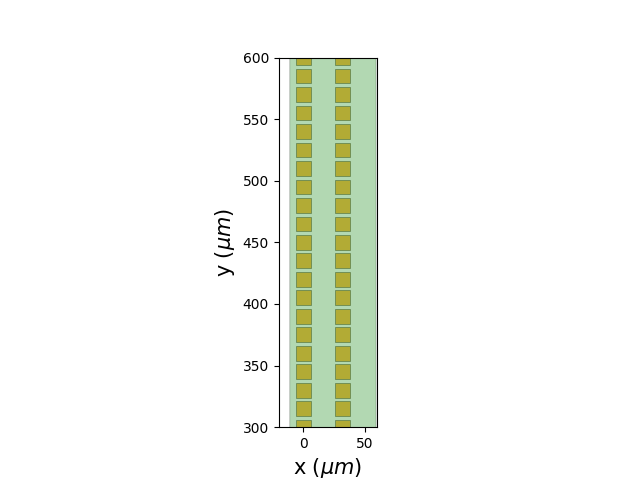

In [12]:
w = si.plot_probe_map(rec_to_compress)
w.ax.set_xlim(-20, 60)
w.ax.set_ylim(300, 600)

In [13]:
total_bytes = rec_oe.get_num_samples() * rec_oe.get_num_channels() * rec_oe.get_dtype().itemsize

# LOSSLESS

### FLAC

In [ ]:
# flac_stream = test_audio_folder / "flac_stream"
# flac_concat = test_audio_folder / "flac_concat"
# rec_audio_flac_stream = write_recording_audio(rec_to_compress, flac_stream, cformat="flac",
#                                               overwrite=True, mode="stream", **job_kwargs)

# rec_audio_flac_concat = write_recording_audio(rec_to_compress, flac_concat, cformat="flac",
#                                               overwrite=True, mode="concat", **job_kwargs)

In [14]:
zarr_path = test_audio_folder / f"flac-si-{np_version}.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)

rec_flac_zarr = rec_to_compress.save(format="zarr", zarr_path=zarr_path, flatten=True,
                                     compressor=FlacCodec(compression_level=8),
                                     **job_kwargs)

zarr_path = test_audio_folder / f"flac-si-{np_version}2.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)

rec_flac_zarr2 = rec_to_compress.save(format="zarr", zarr_path=zarr_path, flatten=True,
                                      compressor=FlacCodec(compression_level=8),
                                      channels_per_chunk=2,
                                      **job_kwargs)

write_zarr_recording with n_jobs 10  chunk_size 30000


write_zarr_recording: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:32<00:00, 22.28it/s]


Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized
write_zarr_recording with n_jobs 10  chunk_size 30000


write_zarr_recording: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:32<00:00, 22.22it/s]


Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized


In [ ]:
job_kwargs["n_jobs"] = 1

In [ ]:
zarr_path = test_audio_folder / f"flac-si-{np_version}2.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)

rec_flac_zarr2 = rec_to_compress.save(format="zarr", zarr_path=zarr_path, flatten=True,
                                      compressor=FlacCodec(compression_level=8),
                                      channels_per_chunk=2,
                                      **job_kwargs)

In [ ]:
from numcodecs import Blosc

In [ ]:
zarr_path = test_audio_folder / f"zstd-{np_version}.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)
    
compressor = Blosc(cname='zstd', clevel=9, shuffle=Blosc.BITSHUFFLE)

rec_zstd_zarr = rec_to_compress.save(format="zarr", zarr_path=zarr_path,
                                     compressor=compressor,
                                     **job_kwargs)

In [ ]:
zarr_path = test_audio_folder / f"zstd-{np_version}-4chans.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)
    
rec_zstd_zarr4 = rec_to_compress.save(format="zarr", 
                                      zarr_path=zarr_path, flatten=True,
                                      compressor=compressor,
                                      channel_chunk_size=4,
                                      **job_kwargs)

In [ ]:
print(f"CR ZSTD - flatten: {rec_zstd_zarr.get_annotation('compression_ratio')}")

print(f"CR ZSTD - 8-channels: {rec_zstd_zarr8.get_annotation('compression_ratio')}")

print(f"CR ZSTD - 4-channels: {rec_zstd_zarr4.get_annotation('compression_ratio')}")

In [ ]:
print(f"CR FLAC SI - flatten: {rec_flac_zarr.get_annotation('compression_ratio')}")

print(f"CR FLAC SI - 2-channels: {rec_flac_zarr2.get_annotation('compression_ratio')}")

In [ ]:
tr_or = rec_to_compress.get_traces(end_frame=30000)
tr_flac = rec_flac_zarr.get_traces(end_frame=30000)
tr_flac2 = rec_flac_zarr2.get_traces(end_frame=30000)


In [ ]:
plt.figure()

plt.plot(tr_or[:, 100])
plt.plot(tr_flac[:, 100])
plt.plot(tr_flac2[:, 100])

In [ ]:
total_bytes_flac_stream = get_dir_size(flac_stream)
cr_flac_stream = total_bytes / total_bytes_flac_stream
print(f"CR FLAC - stream mode: {cr_flac_stream}")

total_bytes_flac_concat = get_dir_size(flac_concat)
cr_flac_concat = total_bytes / total_bytes_flac_concat
print(f"CR FLAC - concat mode: {cr_flac_concat}")



### WAVPACK - lossless

In [ ]:
# wv_stream = test_audio_folder / "wv_stream"
# wv_concat = test_audio_folder / "wv_concat"

In [ ]:
# rec_audio_wv_stream = write_recording_audio(rec_to_compress, wv_stream, cformat="wavpack",
#                                             overwrite=True, mode="stream", **job_kwargs)
# # rec_audio_wv_concat = write_recording_audio(rec_to_compress, wv_concat, cformat="wavpack",
# #                                      overwrite=True, mode="concat", **job_kwargs)

In [ ]:
rec_to_compress

In [16]:
zarr_path = test_audio_folder / "wavpack-si.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)

rec_wv_zarr = rec_to_compress.save(format="zarr", zarr_path=zarr_path, 
                                   compressor=WavPackCodec(compression_mode="h"),
                                   **job_kwargs)    

write_zarr_recording with n_jobs 10  chunk_size 30000


write_zarr_recording: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:48<00:00, 15.12it/s]

Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized


In [17]:
zarr_path = test_audio_folder / "wavpack-si-corr.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)

rec_wv_zarr_nocc = rec_to_compress.save(format="zarr", zarr_path=zarr_path, 
                                        compressor=WavPackCodec(compression_mode="h", hybrid_factor=2),
                                        **job_kwargs) 

write_zarr_recording with n_jobs 10  chunk_size 30000


write_zarr_recording: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [00:58<00:00, 12.57it/s]

Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized


In [15]:
zarr_path = test_audio_folder / "wavpack-si-corr.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)

rec_wv_zarr_cc = rec_to_compress.save(format="zarr", zarr_path=zarr_path, 
                                      compressor=WavPackCodec(compression_mode="h", hybrid_factor=2, cc=True),
                                      **job_kwargs) 

write_zarr_recording with n_jobs 10  chunk_size 30000


write_zarr_recording: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 733/733 [01:03<00:00, 11.47it/s]

Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized


In [18]:
print(f"CR WV SI: {rec_wv_zarr.get_annotation('compression_ratio')}")
print(f"CR WV SI - hybrid - NO CC: {rec_wv_zarr_nocc.get_annotation('compression_ratio')}")
print(f"CR WV SI - hybrid - CC: {rec_wv_zarr_cc.get_annotation('compression_ratio')}")

CR WV SI: 2.3444542823491332
CR WV SI - hybrid - NO CC: 6.8980750740101255
CR WV SI - hybrid - CC: 6.898637568128799


In [ ]:
rec_wv_zarr_c.get_traces(end_frame=100)

In [ ]:
zarr_path = test_audio_folder / "wavpack-si-shuffle.zarr"

if zarr_path.is_dir():
    shutil.rmtree(zarr_path)
rec_wv_zarr_sh = rec_to_compress.save(format="zarr", zarr_path=zarr_path, 
                                   compressor=WavPackCodec(compression_mode="hh"),
                                   filters=[shuffle],
                                   **job_kwargs)

In [ ]:
numcodecs.registry.codec_registry

In [ ]:
print(f"CR WV no shuffle: {rec_wv_zarr.get_annotation('compression_ratio')}")
print(f"CR WV shuffle: {rec_wv_zarr_sh.get_annotation('compression_ratio')}")

In [ ]:
hybryd_factors = [None, 4, 3, 2.5, 2]

rec_wv_dict = {}

for hf in hybryd_factors:
    print(f"Hybrid factor: {hf}")
    zarr_path = test_audio_folder / f"wavpack-si-lossy-{hf}.zarr"

    if zarr_path.is_dir():
        shutil.rmtree(zarr_path)

    rec_wv_zarr_lossy = rec_to_compress.save(format="zarr", zarr_path=zarr_path, 
                                             compressor=WavPackCodec(compression_mode="h", hybrid_factor=hf),
                                             **job_kwargs)
    if hf is None:
        rec_wv_dict[0] = rec_wv_zarr_lossy
    else:
        rec_wv_dict[hf] = rec_wv_zarr_lossy
    print(f"CR WV SI LOSSY - hf {hf}: {rec_wv_zarr_lossy.get_annotation('compression_ratio')}")

In [ ]:
channel_id = 150

plt.figure()

for hf, rec in rec_wv_dict.items():
    tr = rec.get_traces(end_frame=30000)
    plt.plot(tr[:, channel_id], label=f"{hf}", alpha=0.8)
plt.legend()

In [ ]:
# total_bytes_wv = get_dir_size(wv_stream)
# cr_wv_stream = total_bytes / total_bytes_wv 
# print(f"CR WV - stream: {cr_wv_stream}")

# total_bytes_wv = get_dir_size(wv_concat)
# cr_wv_concat = total_bytes / total_bytes_wv 
# print(f"CR WV - concat: {cr_wv_concat}")

print(f"CR WV SI - concat mode: {rec_wv_zarr.get_annotation('compression_ratio')}")

print(f"CR WV SI LOSSY - concat mode: {rec_wv_zarr_lossy.get_annotation('compression_ratio')}")

# tr_or = rec_to_compress.get_traces(end_frame=30000)
# tr_wv = rec_wv_zarr.get_traces(end_frame=30000)
# tr_wv_lossy = rec_wv_zarr_lossy.get_traces(end_frame=30000)


# plt.plot(tr_or[:, 100])
# plt.plot(tr_wv[:, 100])
# plt.plot(tr_wv_lossy[:, 100])

# LOSSY

In [ ]:
mp3_file = test_audio_folder / "mp3_stream"

In [ ]:
rec_audio_mp3 = write_recording_audio(rec_to_compress, mp3_file, cformat="mp3",
                                      overwrite=True, mode="stream", **job_kwargs)

In [ ]:
total_bytes_mp3 = get_dir_size(mp3_file)
cr_mp3 = total_bytes / total_bytes_mp3 
print(f"CR MP3: {cr_mp3}")

In [ ]:
wv_file_lossy = test_audio_folder / "wv_stream_lossy"

In [ ]:
rec_audio_wv_lossy = write_recording_audio(rec_to_compress, wv_file_lossy, cformat="wavpack",
                                           lossless=False, overwrite=True, mode="stream", **job_kwargs)

In [ ]:
total_bytes_wv_lossy = get_dir_size(wv_file_lossy)
cr_wv_lossy = total_bytes / total_bytes_wv_lossy 
print(f"CR WV-HYBRID: {cr_wv_lossy}")

In [ ]:
# check traces

In [ ]:
t_start = time.perf_counter()
tr_flac_str = rec_flac_zarr2.get_traces(start_frame=start_frame, end_frame=end_frame,
                                    channel_ids=channel_ids)
t_stop = time.perf_counter()
elapsed_time_flac = np.round(t_stop - t_start, 2)
print(f"FLAC {ch} - flatten - num channels {nc}: {elapsed_time_flac} s")


In [ ]:
#stream VS concat

snippet_durations = [0.5, 1, 2, 5]
num_chunks = 3
num_channels = [10, 384]
num_samples = rec_to_compress.get_num_samples()

for dur in snippet_durations:
    print(f"Snippet duration {dur}s")
#     fig, axs = plt.subplots(nrows=num_chunks, ncols=len(num_channels))
    for ch in range(num_chunks):
        samples = int(rec_to_compress.get_sampling_frequency() * dur)
        start_frame = np.random.randint(num_samples - samples - 1)
        end_frame = start_frame + samples
        
        for inc, nc in enumerate(num_channels):
            channel_ids = rec_to_compress.channel_ids[np.random.permutation(rec_to_compress.get_num_channels())[:nc]]
            
            random_channel = np.random.randint(nc)
            tr_or = rec_to_compress.get_traces(start_frame=start_frame, end_frame=end_frame,
                                               channel_ids=channel_ids)
            t_start = time.perf_counter()
            tr_flac_str = rec_flac_zarr2.get_traces(start_frame=start_frame, end_frame=end_frame,
                                                channel_ids=channel_ids)
            t_stop = time.perf_counter()
            elapsed_time_flac = np.round(t_stop - t_start, 2)
            print(f"FLAC {ch} - flatten - num channels {nc}: {elapsed_time_flac} s")
            
            t_start = time.perf_counter()
            tr_flac_cnc = rec_flac_zarr2.get_traces(start_frame=start_frame, end_frame=end_frame,
                                                channel_ids=channel_ids)
            t_stop = time.perf_counter()
            elapsed_time_flac = np.round(t_stop - t_start, 2)
            print(f"FLAC {ch} - 2-chans - num channels {nc}: {elapsed_time_flac} s")
            
#             axs[ch, inc].plot(tr_or[:, random_channel], "k", label="GT", lw=2, alpha=0.8)
#             axs[ch, inc].plot(tr_flac_str[:, random_channel], "C0", label="FLAC", alpha=0.8)            
#             axs[ch, inc].plot(tr_flac_cnc[:, random_channel], "C1", label="WV", alpha=0.8)            

In [ ]:
plt.figure()

plt.plot(tr_or[:, 0])
plt.plot(tr_flac_str[:, 0])
plt.plot(tr_flac_cnc[:, 0])

In [ ]:
snippet_durations = [0.5, 1, 2, 5]
num_chunks = 3
num_channels = [10, 384]
num_samples = rec_to_compress.get_num_samples()

for dur in snippet_durations:
    print(f"Snippet duration {dur}s")
    fig, axs = plt.subplots(nrows=num_chunks, ncols=len(num_channels))
    for ch in range(num_chunks):
        samples = int(rec_to_compress.get_sampling_frequency() * dur)
        start_frame = np.random.randint(num_samples - samples - 1)
        end_frame = start_frame + samples
        
        for inc, nc in enumerate(num_channels):
            channel_ids = rec_to_compress.channel_ids[np.random.permutation(rec_to_compress.get_num_channels())[:nc]]
            
            random_channel = np.random.randint(nc)
            tr_or = rec_to_compress.get_traces(start_frame=start_frame, end_frame=end_frame,
                                               channel_ids=channel_ids)
            t_start = time.perf_counter()
            tr_flac = rec_audio_flac.get_traces(start_frame=start_frame, end_frame=end_frame,
                                                channel_ids=channel_ids)
            t_stop = time.perf_counter()
            elapsed_time_flac = np.round(t_stop - t_start, 2)
            print(f"FLAC {ch} - dur{dur} - num channels {nc}: {elapsed_time_flac} s")
            
            t_start = time.perf_counter()
            tr_wv = rec_audio_wv.get_traces(start_frame=start_frame, end_frame=end_frame,
                                            channel_ids=channel_ids)
            t_stop = time.perf_counter()
            elapsed_time_wv = np.round(t_stop - t_start, 2)
            print(f"WV test{ch} - num channels {nc}: {elapsed_time_wv} s")
            
            axs[ch, inc].plot(tr_or[:, random_channel], "k", label="GT", lw=2, alpha=0.8)
            axs[ch, inc].plot(tr_flac[:, random_channel], "C0", label="FLAC", alpha=0.8)            
            axs[ch, inc].plot(tr_wv[:, random_channel], "C1", label="WV", alpha=0.8)            

In [ ]:
snippet_durations = [0.5, 1, 2, 5]
num_chunks = 3
num_channels = [10, 384]
num_samples = rec_to_compress.get_num_samples()

for dur in snippet_durations:
    print(f"Snippet duration {dur}s")
    fig, axs = plt.subplots(nrows=num_chunks, ncols=len(num_channels))
    for ch in range(num_chunks):
        samples = int(rec_to_compress.get_sampling_frequency() * dur)
        start_frame = np.random.randint(num_samples - samples - 1)
        end_frame = start_frame + samples
        
        for inc, nc in enumerate(num_channels):
            channel_ids = rec_to_compress.channel_ids[np.random.permutation(rec_to_compress.get_num_channels())[:nc]]
            
            random_channel = np.random.randint(nc)
            tr_or = rec_to_compress.get_traces(start_frame=start_frame, end_frame=end_frame,
                                               channel_ids=channel_ids)
            t_start = time.perf_counter()
            tr_mp3 = rec_audio_mp3.get_traces(start_frame=start_frame, end_frame=end_frame,
                                                channel_ids=channel_ids)
            t_stop = time.perf_counter()
            elapsed_time_mp3 = np.round(t_stop - t_start, 2)
            print(f"MP3 {ch} - dur{dur} - num channels {nc}: {elapsed_time_mp3} s")
            
            axs[ch, inc].plot(tr_or[:, random_channel], "k", label="GT", lw=2, alpha=0.8)
            axs[ch, inc].plot(tr_mp3[:, random_channel], "C0", label="MP3", alpha=0.8)            


### Spike sort LOSSY

In [ ]:
sorter = "kilosort2_5"
sorter_params = {"n_jobs_bin": 10, "total_memory": "100M"}

In [ ]:
rec_lossless_preproc = si.bandpass_filter(rec_wv_zarr)
rec_lossless_preproc = si.common_reference(rec_lossless_preproc, reference="local")

In [ ]:
tr_10s = rec_wv_zarr.get_traces(start_frame=int(20*fs), end_frame=int(40*fs))

In [ ]:
sort_wv_KS = si.run_sorter(sorter, rec_lossless_preproc, 
                           output_folder=test_audio_folder / "wv_ks25", verbose=True,
                           **sorter_params)
print(sort_wv_KS)

In [ ]:
rec_lossy_preproc = si.bandpass_filter(rec_wv_zarr_lossy)
rec_lossy_preproc = si.common_reference(rec_lossy_preproc, reference="local")

In [ ]:
sort_wvl_KS = si.run_sorter(sorter, rec_wv_zarr_lossy, output_folder=test_audio_folder / "flac_ks25", 
                            verbose=True, **sorter_params)
print(sort_wvl_KS)

In [ ]:
mcmp = si.compare_multiple_sorters([sort_wv_KS, sort_wvl_KS], name_list=["WV", "WV_LOSSY"], verbose=True)

In [ ]:
si.plot_multicomp_agreement_by_sorter(mcmp)

In [ ]:
si.plot_agreement_matrix(mcmp.comparisons[0])

In [ ]:
cmp_gt = si.compare_sorter_to_ground_truth(sort_wv_KS, sort_wvl_KS)

In [ ]:
len(cmp_gt.get_well_detected_units(well_detected_score=0.8))

In [ ]:
ch_idx = 150

tr_wv = rec_lossless_preproc.get_traces(end_frame=30000)
tr_wv_lossy = rec_lossy_preproc.get_traces(end_frame=30000)

plt.figure()

plt.plot(tr_wv[:, ch_idx])
plt.plot(tr_wv_lossy[:, ch_idx])

In [ ]:
import spikeinterface.full as si
from numcodecs import Blosc

open_ephys_path = "path-to-oe-folder"

recording = si.read_open_ephys(open_ephys_path)

compressor = Blosc(cname="zstd", clevel=5, shuffle=2)

recording_zarr = recording.save(format="zarr", zarr_path="oe-dset.zarr",
                                compressor=compressor)

In [ ]:
storage_options = {token: "my-private-auth"}
zarr_path = "gcs://aind-bucket/oe-dset.zarr"

recording_zarr = recording.save(format="zarr", zarr_path=zarr_path,
                                storage_options=storage_options,
                                compressor=compressor)